### CSCI E-82  Homework 5 on CNNs

### Due by 11/13/18 at 11:59pm EST to the Canvas dropbox

## This is an individual homework so there should be no collaboration for this homework.


### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.


This is a busy time of year with homework and an exam coming up.  We are looking for a successful working result that builds upon the section code and enables you to gain some proficiency with this important and growing field of deep learning. 

Depending on your computer, some of the runs may still take a few minutes per epoch.  As a result, Problem 4 may take the better part of a day to run, so plan accordingly.  

## Your Name: SHARJIL KHAN

In [60]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image

from sklearn.metrics import auc
from sklearn.metrics import roc_curve


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD


from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

Tensorflow is installed and is version:  1.11.0
Keras is installed and is version:  2.1.6-tf
[[22. 28.]
 [49. 64.]]


In [61]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        

def plot_accuracies_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g-', label='Training acc', color = 'brown')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
 
    plt.plot(epochs, loss, 'g-', label='Training loss', color = 'brown')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [62]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

In [63]:
print(sys.version)
print(device_lib.list_local_devices())

3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11104394809493091072
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11165909729231536491
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [64]:
## Given a base directory it creates two directories and uses the truth.txt 
## file to split the files into these two directories
def organize_folders (base_dir):
    truth_file = os.path.join(base_dir,'truth.txt')
    portrait_dir = os.path.join(base_dir, 'portrait')
    landscape_dir = os.path.join(base_dir, 'landscape')

    # CREATE THE TWO FOLDERS IF THEY DONT EXIST ALREADY
    if not os.path.exists(portrait_dir):
             os.makedirs(portrait_dir)
    if not os.path.exists(landscape_dir):
             os.makedirs(landscape_dir)

    with open(truth_file) as f:
        for line in f:
            data = line.split()
            image_file = os.path.join(base_dir, data[0])
            image_type = data[1]
            if os.path.exists(image_file):
                if os.path.getsize(image_file) > 0:
                        if image_type == 'portrait':
                              shutil.move(image_file, portrait_dir)
                        if image_type == 'landscape':
                              shutil.move(image_file, landscape_dir)    
                print ("Moving:%s to %s"%(image_file,image_type))           
                
# SPECIFY THE THREE BASE DIRECTORIES
train_dir = './images64/train'
validation_dir = './images64/validation'
test_dir = './images64/test'

# ORGANISE EACH DIRECTORY INTO PORTRAIT AND LANDSCAPE DIRs
organize_folders(train_dir)
organize_folders(validation_dir)
organize_folders(test_dir)

# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

# generator for the training data
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# generator for the validation data
validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

# generator for the test data
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        # NO shuffle for the test set to be able to track the file names
        shuffle = False,
        batch_size=32,  # this just makes sure it gets through memory
        class_mode='binary')



Found 16315 images belonging to 2 classes.
Found 8158 images belonging to 2 classes.
Found 7379 images belonging to 2 classes.


## Dataset

WikiArt is an amazing resource containing centuries of artwork.  Since such datasets are wonderful for deep learning, Kaggle has hosted a challenge to characterize the 'fingerprints' of various artists.  The Kaggle dataset contains metadata and also a set of images that have been resized so that the shorter dimension is 256 pixels.  To make this homework reasonably fast even for those without GPUs, we have further reduced the images to 64 x 64.  CNNs and neural networks in general prefer to have consistent sizes.  To achieve this, we cut the center 256 pixels from the longer dimension and then shrunk the images by a factor of 4. This isn't a perfect solution since it did cut off a few heads as you will see.

The selected images are for portraits and landscapes.  No, we're not talking about the orientation but rather the content of the images. Thanks to help from Rashmi and Dave, we have a small enough data set that should give reasonable results in a timely manner even on just a CPU.

The data were originally divided into a training and a test set.  We have further divided the training set into a train and validation set.  In this homework you will be using the training set and validation set to train and assess your deep learning models.  At the final step, you will see how well your final training worked on the test set.  In each of these directories, there is a truth.txt file that has the image name and whether it is a portrait or landscape scene.

## Problem 1 (5 points)

Read in and display the first 5 portraits and the first 5 landscapes.  Note, if you are using the OpenCV tools, then the color may be distorted.  The cvtColor() method using cv2.COLOR_BGR2RGB may be useful.  However, it is likely easier to use the generator and plot_strip example from section.

In [65]:
# USE THE TRAIN DATA GENERATOR CREATED ABOVE TO GENERATE FIRST FIVE PORTRAITS AND LANDSCAPES
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

first_five_portraits = []
first_five_landscapes = []
for i, j in enumerate (range(len(labels_batch))):
    if labels_batch[j] == 1:
        first_five_portraits.append(data_batch[j,:,:])
    if labels_batch[j] == 0:
        first_five_landscapes.append(data_batch[j,:,:])
    if i == 10:
        break


data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


FIRST FIVE PORTRAITS GENERATED BY THE TRAINING GENERATOR:


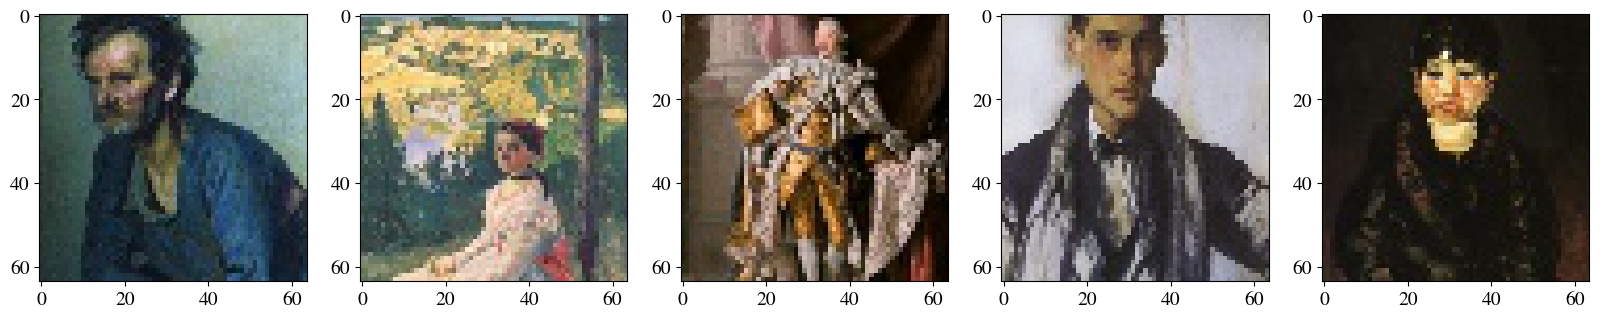

FIRST FIVE LANDSCAPES GENERATED BY THE TRAINING GENERATOR:


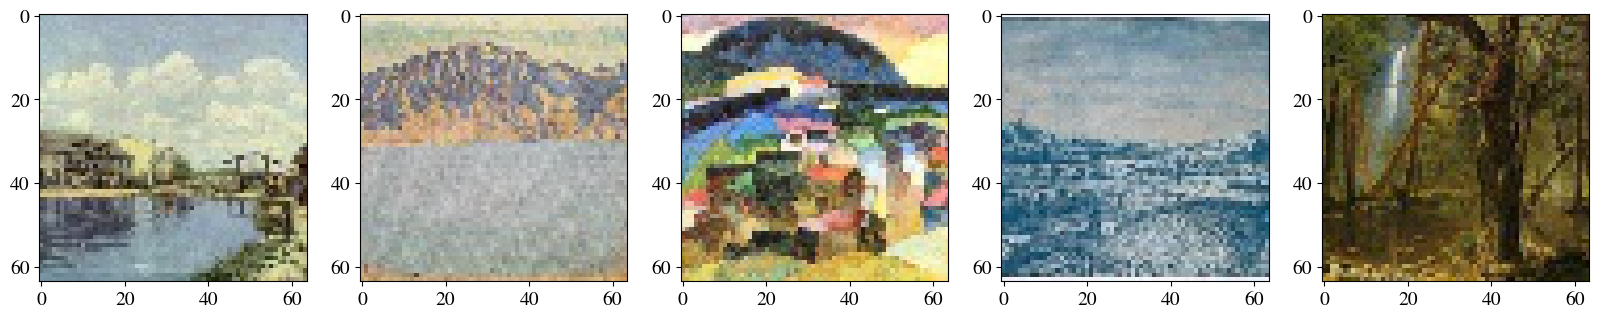

In [66]:
# FUNCTION TO PLOT OUT THE FIRST FIVE IMAGES FROM A LIST
def plot_first_five (lst):    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    f, ax = plt.subplots(nrows=1, ncols=5)
    for i in range(5):
        image = lst[i]
        ax[i].imshow(image)
    plt.show()
    return

print("FIRST FIVE PORTRAITS GENERATED BY THE TRAINING GENERATOR:")
plot_first_five(first_five_portraits)
print("FIRST FIVE LANDSCAPES GENERATED BY THE TRAINING GENERATOR:")
plot_first_five(first_five_landscapes)

## Problem 2 (25 points)

Construct a baseline CNN classifier using Keras for the training set and assess the validation set performance at each epoch. The goal is to correctly classify portraits from landscapes. Plot the resulting performance on the training and validation set as a function of epoch using the criteria over which you are optimizing.  You should run at least 20 epochs for this problem.

In [59]:
K.clear_session()

#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
tensorboard = TrainValTensorBoard("logs/{}".format(time()), write_graph=True)

def simple_model():
    model = Sequential(name='SimpleModel')
    model.add(Conv2D(32, (2, 2), strides = (1, 1), padding='same',activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool1'))
    model.add(Conv2D(64, (2, 2), strides = (1, 1), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool2'))
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))
    
    sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

cnn1_simple = simple_model()
cnn1_simple.summary()

# Fit model
history = cnn1_simple.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[tensorboard])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        416       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              16778240  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 1025      
Total para

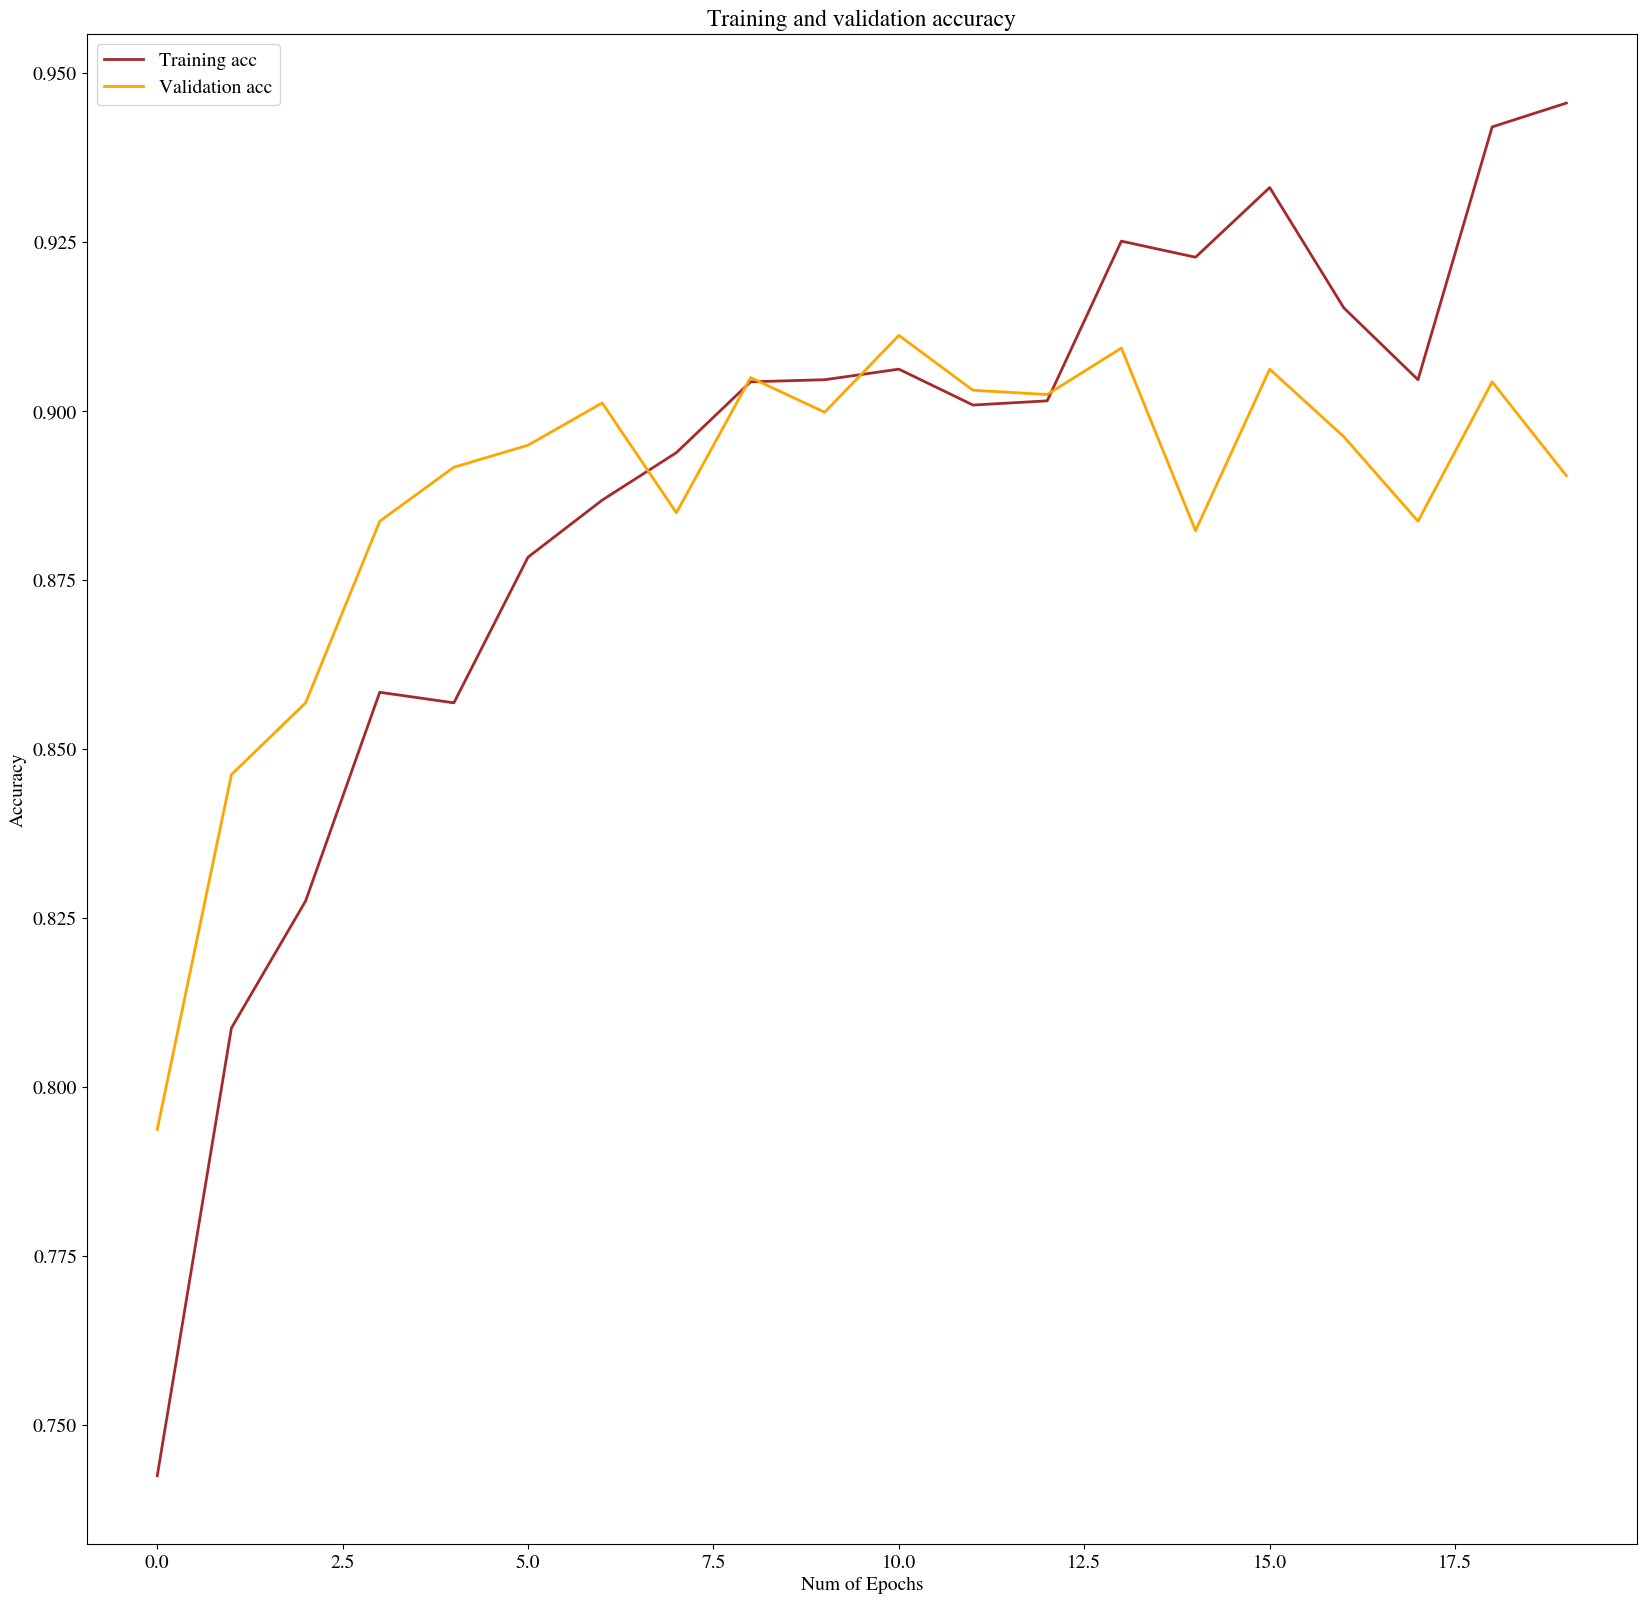

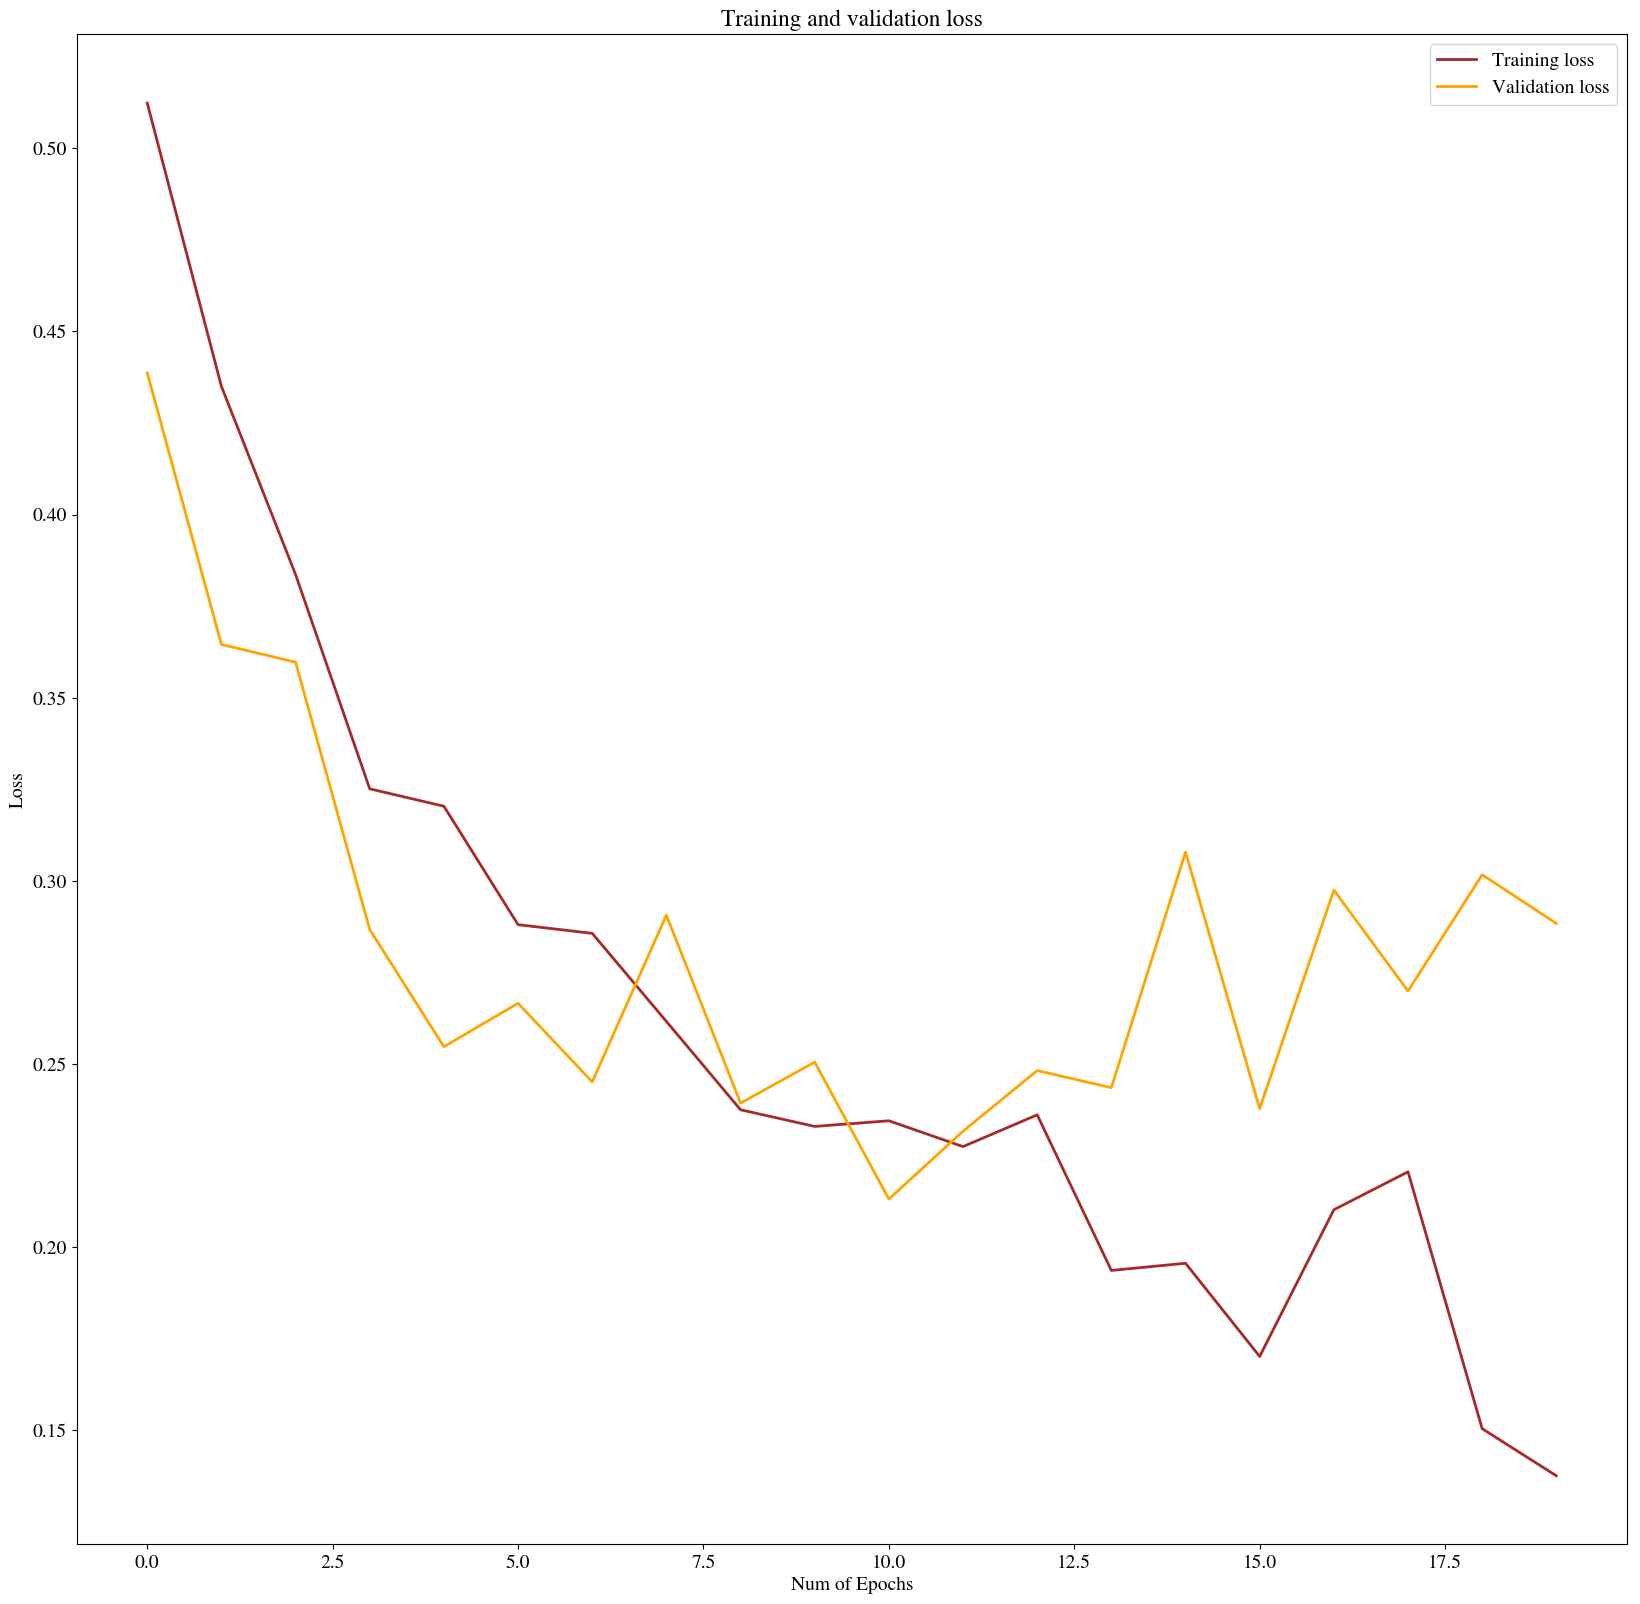

In [68]:
plot_accuracies_loss(history)

## Problem 3 (5 points)

From the pattern of training and validation curves, describe what is good/bad and what you plan to do next to improve the result.

From the above plots, we can see that we are achieving fairly good validation accuracy of about 89 % with this simple model.  
However there are a few things to notice:
1. We are using a kernel size of 2X2 with just two convolution layers of 32 and 64 filters in this simple model. We can certainly make this model more complex and hope to achieve even higher scores.  
2. There is definately overfitting which starts to happen beyond about 11 epochs:
    - We see training scores rising while validation scores beginning to decline. We can add some pooling and regularization to       help with the overfitting.
3. Accuracy and Loss curves hasn't quite flattened out completely at 20 epochs. So after solving the overfitting issue, training for larger epochs might also tune the parameters a little more to achieve higher scores.

STRATEGY SUMMARY:
1. So my strategy will be to add some more layers and see the results of increasing or decreasing the kernel size and number of filters/maps in each layer.  
2. Then, I will fix any overfitting using pooling, batch normalisation & simplifying the model if necessary.
3. Then, I will try to change the activation functions, optimizers and also run for longer epochs to see if scores can be improved.

## Problem 4 (45 points)

This step is where we want you to do most of your personal learning.  Your goal is to improve the network using a combination of architecture choices, parameter tuning, and experimenting with different optimizers/dropout/regularization/etc. Treat each of these as separate optimization/exploration steps for now.  We would like to see 3 separate steps that cover different areas.  The format of the 3 steps should be as follows:
  * State the hypothesis/strategy for how you will improve/explore a particular aspect.
  * Describe what types of tests you are running and why (i.e. what range of parameters are you choosing and why)
  * Include the code and results
  * State your interpretation of the results
 
We're not looking for research in deep learning, but we want you to gain some hands-on experience working with Keras and figuring out what works. A good example may be comparing strategies to overcome overfitting, or comparing a few different CNN architectures in terms of performance and speed, or comparing data augmentation types and results.  
 


#### Strategy 1:  Increase Model Complexity to try to achieve higher scores 
    - Add 4 more layers with increasingly larger number of filters as we narrow down the map size with a few pooling layers  
      in between.
    - Also increased the number of epochs we are training the parameters for to see if accuracies would eventually increase. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 128)         147584    
__________

Epoch 47/60
100/100 [==============================] - 3s 35ms/step - loss: 0.1023 - acc: 0.9594 - val_loss: 0.1844 - val_acc: 0.9287
Epoch 48/60
100/100 [==============================] - 4s 35ms/step - loss: 0.0954 - acc: 0.9628 - val_loss: 0.2139 - val_acc: 0.9262
Epoch 49/60
100/100 [==============================] - 4s 35ms/step - loss: 0.0905 - acc: 0.9675 - val_loss: 0.2421 - val_acc: 0.9237
Epoch 50/60
100/100 [==============================] - 3s 35ms/step - loss: 0.0831 - acc: 0.9666 - val_loss: 0.1721 - val_acc: 0.9387
Epoch 51/60
100/100 [==============================] - 4s 35ms/step - loss: 0.0838 - acc: 0.9669 - val_loss: 0.2032 - val_acc: 0.9300
Epoch 52/60
100/100 [==============================] - 4s 35ms/step - loss: 0.0900 - acc: 0.9656 - val_loss: 0.1519 - val_acc: 0.9487
Epoch 53/60
100/100 [==============================] - 4s 35ms/step - loss: 0.0778 - acc: 0.9730 - val_loss: 0.2650 - val_acc: 0.9305
Epoch 54/60
100/100 [==============================] - 4s 35ms

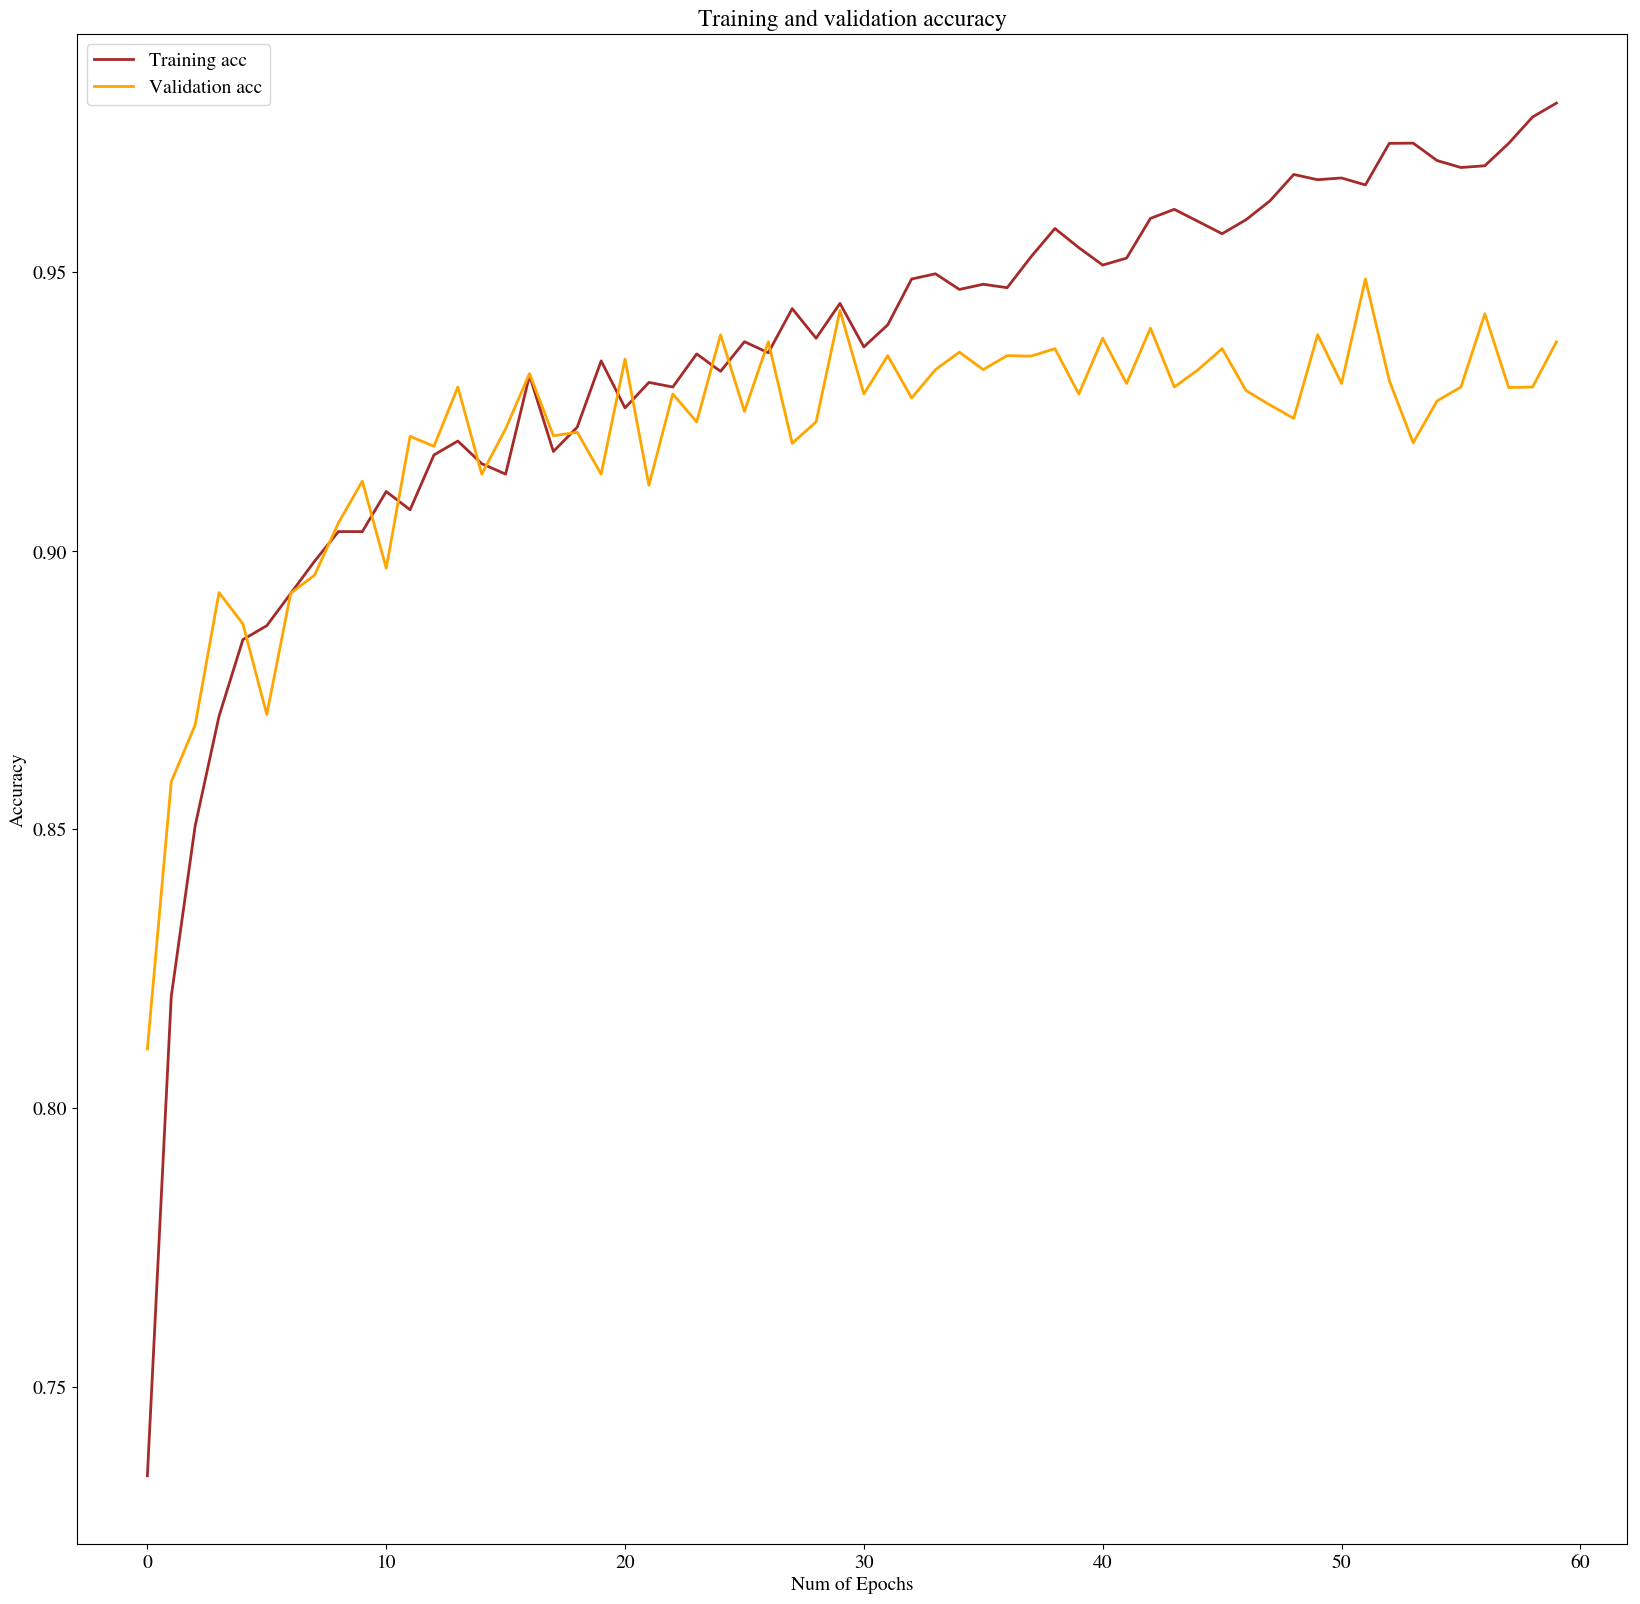

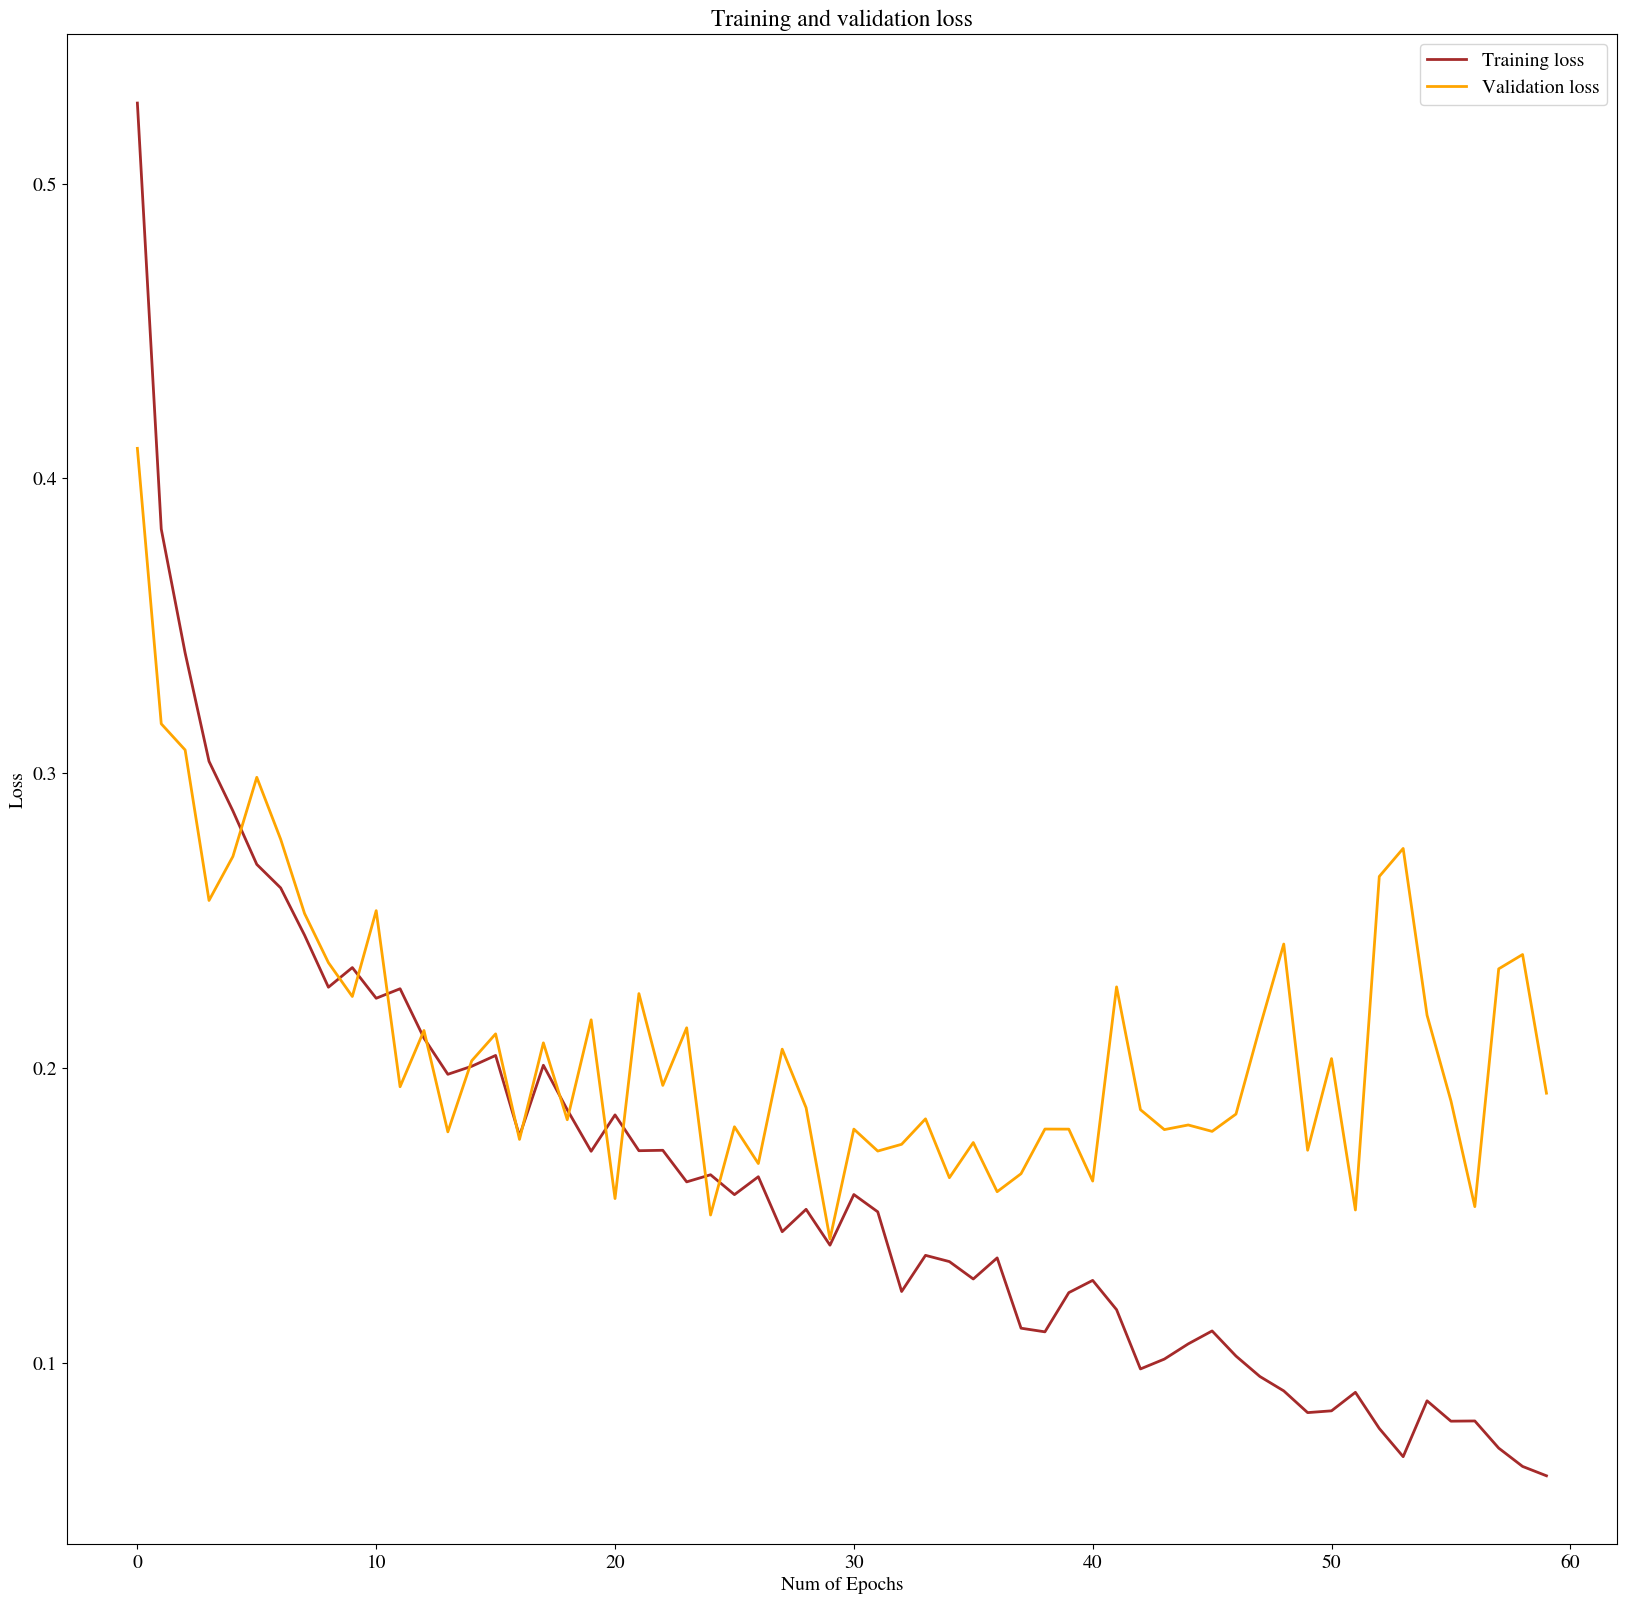

In [71]:
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
K.clear_session()

def more_complex_model():

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv4'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name = 'conv5'))
    model.add(Conv2D(512,(3, 3), padding='same', activation='relu', name = 'conv6'))
    model.add(MaxPooling2D((2, 2), name='max_pool6'))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model

cnn_more_complex = more_complex_model()
cnn_more_complex.summary()

# Fit model
history_complex = cnn_more_complex.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)])

plot_accuracies_loss(history_complex)

#### INTERPRETATION OF RESULTS FOR STRATEGY 1: 
We see that increasing the number of layers and number of epochs have increased the accuracy score by about 5%.  
But as we run for more epochs we also see a clear divergence between training set accuracy and validation set accuracy. In the next step we will try to reduce the overfit.

#### Strategy 2: Try to reduce overfit by adding pooling, dropout and simplifying the model a little bit.
- Increase Pooling Layers and decrease the number of filters in each layer to minimize overfit.
- Also add a few dropout layers


In [23]:

#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
K.clear_session()

def more_complex_model():

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv4'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name = 'conv5'))
    model.add(Conv2D(512,(3, 3), padding='same', activation='relu', name = 'conv6'))
    model.add(MaxPooling2D((2, 2), name='max_pool6'))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model

cnn_more_complex = more_complex_model()
cnn_more_complex.summary()

# Fit model
history_complex = cnn_more_complex.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)])

plot_accuracies_loss(history_complex)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 128)         147584    
__________

Epoch 47/60
100/100 [==============================] - 4s 38ms/step - loss: 0.0885 - acc: 0.9694 - val_loss: 0.1641 - val_acc: 0.9468
Epoch 48/60
100/100 [==============================] - 4s 38ms/step - loss: 0.0744 - acc: 0.9675 - val_loss: 0.2108 - val_acc: 0.9406
Epoch 49/60
100/100 [==============================] - 4s 39ms/step - loss: 0.0881 - acc: 0.9653 - val_loss: 0.1969 - val_acc: 0.9275
Epoch 50/60
100/100 [==============================] - 4s 38ms/step - loss: 0.0805 - acc: 0.9672 - val_loss: 0.2026 - val_acc: 0.9325
Epoch 51/60
100/100 [==============================] - 4s 38ms/step - loss: 0.1019 - acc: 0.9628 - val_loss: 0.1659 - val_acc: 0.9387
Epoch 52/60
100/100 [==============================] - 4s 38ms/step - loss: 0.0591 - acc: 0.9765 - val_loss: 0.2549 - val_acc: 0.9237
Epoch 53/60
100/100 [==============================] - 4s 38ms/step - loss: 0.0610 - acc: 0.9750 - val_loss: 0.2292 - val_acc: 0.9281
Epoch 54/60
100/100 [==============================] - 4s 38ms

#### INTERPRETATION OF RESULTS FOR STRATEGY 2: 
We see that increasing the number of layers and number of epochs have increased the accuracy score by about 5%.  
But as we run for more epochs we also see a clear divergence between training set accuracy and validation set accuracy. In the next step we will try to reduce the overfit.


test accuracy: 0.9382500010728836
test loss: 0.17088459450751542


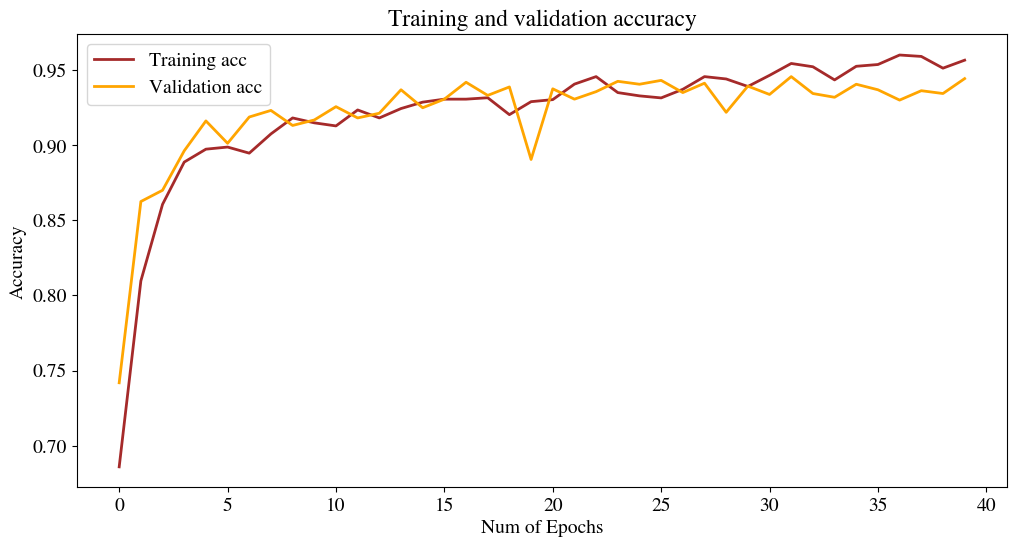

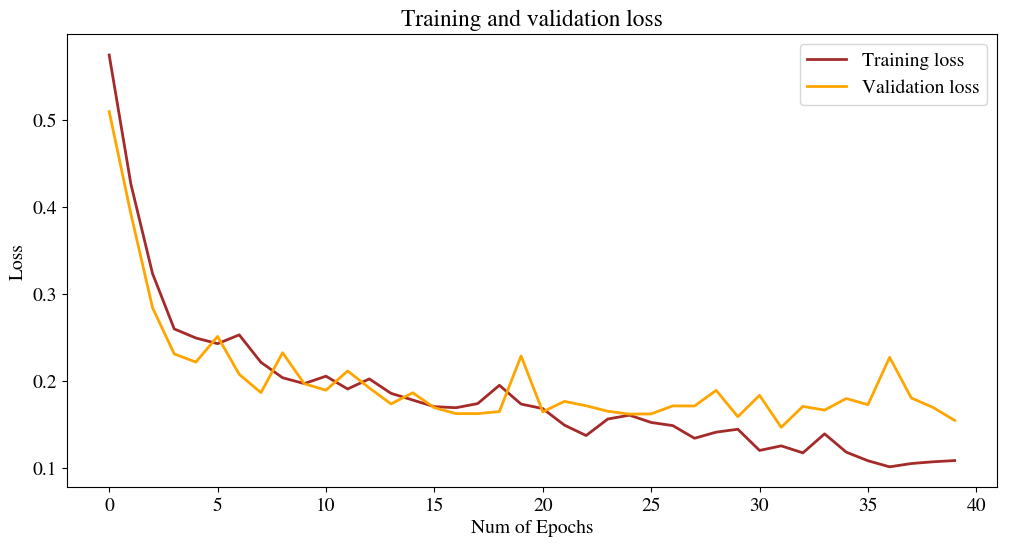

In [59]:
test_loss, test_acc = cnn_five.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)

plot_accuracies_loss(history_five)

#### Strategy 3: 

In [ ]:
K.clear_session()

#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
tensorboard = TrainValTensorBoard("logs/{}".format(time()), write_graph=True)

def dropout_model():

    model = Sequential(name='SimpleModel')
    model.add(Conv2D(32, (4, 4), strides = (1, 1), padding='same',activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool1'))
    model.add(Conv2D(64, (4, 4), strides = (1, 1), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool2'))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))
    
    sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

cnn1 = dropout_model()
cnn1.summary()

# Fit model
history = cnn1.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[tensorboard])


plot_accuracies_loss(history)

## Problem 5 (10 points)

Assess your best model on the test data.  Plot the corresponding ROC curve from the results (since we've provided the truth).  This was not directly covered in section, but will require a prediction using images in the same format as the training.  We suggest referring to the Keras API else use a Google to search to find how to make predictions.

In [24]:
### PICK THE BEST MODEL #####
best_model = cnn_five

test_loss, test_acc = best_model.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)


predictions = []
labels = []
indexes = []

i = 0
for data_batch, labels_batch in test_generator:
    labels.extend(labels_batch)
    predictions.extend(best_model.predict(data_batch).T[0])
    i = i + 1
    if i==len(test_generator):
        break
        
for i in range (len(test_generator)):
     indexes.extend(next(test_generator.index_generator))
        
print(len(indexes))
print(len(labels))
print(len(predictions))



test accuracy: 0.9321875
test loss: 0.27338063922710715
7379
7379
7379


In [25]:
for i in range(len(indexes)):
    print(test_generator.filenames[indexes[i]])
    print(labels[i])


portrait/78796.jpg
1.0
portrait/78801.jpg
1.0
portrait/78834.jpg
1.0
portrait/78876.jpg
1.0
portrait/78923.jpg
1.0
portrait/78979.jpg
1.0
portrait/79011.jpg
1.0
portrait/79032.jpg
1.0
portrait/79043.jpg
1.0
portrait/79050.jpg
1.0
portrait/79052.jpg
1.0
portrait/79071.jpg
1.0
portrait/79077.jpg
1.0
portrait/79086.jpg
1.0
portrait/79110.jpg
1.0
portrait/79113.jpg
1.0
portrait/79117.jpg
1.0
portrait/79122.jpg
1.0
portrait/79129.jpg
1.0
portrait/79137.jpg
1.0
portrait/79149.jpg
1.0
portrait/79155.jpg
1.0
portrait/79161.jpg
1.0
portrait/79203.jpg
1.0
portrait/79211.jpg
1.0
portrait/79220.jpg
1.0
portrait/79229.jpg
1.0
portrait/79259.jpg
1.0
portrait/79330.jpg
1.0
portrait/7938.jpg
1.0
portrait/79380.jpg
1.0
portrait/79391.jpg
1.0
portrait/79437.jpg
1.0
portrait/79483.jpg
1.0
portrait/7949.jpg
1.0
portrait/79498.jpg
1.0
portrait/79559.jpg
1.0
portrait/79606.jpg
1.0
portrait/79607.jpg
1.0
portrait/79622.jpg
1.0
portrait/79651.jpg
1.0
portrait/79653.jpg
1.0
portrait/79668.jpg
1.0
portrait/7971

landscape/12265.jpg
0.0
landscape/12299.jpg
0.0
landscape/12301.jpg
0.0
landscape/12387.jpg
0.0
landscape/1239.jpg
0.0
landscape/12435.jpg
0.0
landscape/12493.jpg
0.0
landscape/12600.jpg
0.0
landscape/12681.jpg
0.0
landscape/12702.jpg
0.0
landscape/12728.jpg
0.0
landscape/12771.jpg
0.0
landscape/12774.jpg
0.0
landscape/12788.jpg
0.0
landscape/12796.jpg
0.0
landscape/12798.jpg
0.0
landscape/12813.jpg
0.0
landscape/12834.jpg
0.0
landscape/12842.jpg
0.0
landscape/12872.jpg
0.0
landscape/12910.jpg
0.0
landscape/12914.jpg
0.0
landscape/12939.jpg
0.0
landscape/13039.jpg
0.0
landscape/1307.jpg
0.0
landscape/13081.jpg
0.0
landscape/13117.jpg
0.0
landscape/13121.jpg
0.0
landscape/13137.jpg
0.0
landscape/13209.jpg
0.0
landscape/13254.jpg
0.0
landscape/13272.jpg
0.0
landscape/1328.jpg
0.0
landscape/133.jpg
0.0
landscape/13355.jpg
0.0
landscape/13364.jpg
0.0
landscape/13437.jpg
0.0
landscape/13439.jpg
0.0
landscape/13470.jpg
0.0
landscape/13495.jpg
0.0
landscape/13585.jpg
0.0
landscape/13665.jpg
0

landscape/37948.jpg
0.0
landscape/3795.jpg
0.0
landscape/37987.jpg
0.0
landscape/3801.jpg
0.0
landscape/38013.jpg
0.0
landscape/38044.jpg
0.0
landscape/3806.jpg
0.0
landscape/38136.jpg
0.0
landscape/38139.jpg
0.0
landscape/38140.jpg
0.0
landscape/38167.jpg
0.0
landscape/38213.jpg
0.0
landscape/38221.jpg
0.0
landscape/3823.jpg
0.0
landscape/38230.jpg
0.0
landscape/38271.jpg
0.0
landscape/38291.jpg
0.0
landscape/38296.jpg
0.0
landscape/38335.jpg
0.0
landscape/38365.jpg
0.0
landscape/3839.jpg
0.0
landscape/38421.jpg
0.0
landscape/38438.jpg
0.0
landscape/38441.jpg
0.0
landscape/38444.jpg
0.0
landscape/38467.jpg
0.0
landscape/38469.jpg
0.0
landscape/38484.jpg
0.0
landscape/38488.jpg
0.0
landscape/38491.jpg
0.0
landscape/3854.jpg
0.0
landscape/38571.jpg
0.0
landscape/38747.jpg
0.0
landscape/38779.jpg
0.0
landscape/38817.jpg
0.0
landscape/38818.jpg
0.0
landscape/38823.jpg
0.0
landscape/38904.jpg
0.0
landscape/38935.jpg
0.0
landscape/3898.jpg
0.0
landscape/39002.jpg
0.0
landscape/39041.jpg
0.0

0.0
landscape/64948.jpg
0.0
landscape/64997.jpg
0.0
landscape/65011.jpg
0.0
landscape/65035.jpg
0.0
landscape/65062.jpg
0.0
landscape/6508.jpg
0.0
landscape/6511.jpg
0.0
landscape/65128.jpg
0.0
landscape/65139.jpg
0.0
landscape/65186.jpg
0.0
landscape/65238.jpg
0.0
landscape/65263.jpg
0.0
landscape/65332.jpg
0.0
landscape/65344.jpg
0.0
landscape/65361.jpg
0.0
landscape/6537.jpg
0.0
landscape/65449.jpg
0.0
landscape/65486.jpg
0.0
landscape/65512.jpg
0.0
landscape/65550.jpg
0.0
landscape/65553.jpg
0.0
landscape/65570.jpg
0.0
landscape/65590.jpg
0.0
landscape/65636.jpg
0.0
landscape/65638.jpg
0.0
landscape/65711.jpg
0.0
landscape/65729.jpg
0.0
landscape/65774.jpg
0.0
landscape/6586.jpg
0.0
landscape/65957.jpg
0.0
landscape/6598.jpg
0.0
landscape/66001.jpg
0.0
landscape/66023.jpg
0.0
landscape/66034.jpg
0.0
landscape/66076.jpg
0.0
landscape/66096.jpg
0.0
landscape/66258.jpg
0.0
landscape/66273.jpg
0.0
landscape/66361.jpg
0.0
landscape/66371.jpg
0.0
landscape/66372.jpg
0.0
landscape/66384.j

landscape/87637.jpg
0.0
landscape/87671.jpg
0.0
landscape/87708.jpg
0.0
landscape/87731.jpg
0.0
landscape/87751.jpg
0.0
landscape/87759.jpg
0.0
landscape/87764.jpg
0.0
landscape/87768.jpg
0.0
landscape/87778.jpg
0.0
landscape/87801.jpg
0.0
landscape/87808.jpg
0.0
landscape/87817.jpg
0.0
landscape/8783.jpg
0.0
landscape/87883.jpg
0.0
landscape/87889.jpg
0.0
landscape/87891.jpg
0.0
landscape/87957.jpg
0.0
landscape/8797.jpg
0.0
landscape/88023.jpg
0.0
landscape/88066.jpg
0.0
landscape/88092.jpg
0.0
landscape/88097.jpg
0.0
landscape/88130.jpg
0.0
landscape/88138.jpg
0.0
landscape/88149.jpg
0.0
landscape/88153.jpg
0.0
landscape/88162.jpg
0.0
landscape/88163.jpg
0.0
landscape/88173.jpg
0.0
landscape/88258.jpg
0.0
landscape/8833.jpg
0.0
landscape/88334.jpg
0.0
landscape/88395.jpg
0.0
landscape/88453.jpg
0.0
landscape/88459.jpg
0.0
landscape/88482.jpg
0.0
landscape/88486.jpg
0.0
landscape/88525.jpg
0.0
landscape/88531.jpg
0.0
landscape/88536.jpg
0.0
landscape/88629.jpg
0.0
landscape/88684.jpg

1.0
portrait/22959.jpg
1.0
portrait/22978.jpg
1.0
portrait/2305.jpg
1.0
portrait/23054.jpg
1.0
portrait/23061.jpg
1.0
portrait/2308.jpg
1.0
portrait/23139.jpg
1.0
portrait/23153.jpg
1.0
portrait/23191.jpg
1.0
portrait/23287.jpg
1.0
portrait/23351.jpg
1.0
portrait/23372.jpg
1.0
portrait/23454.jpg
1.0
portrait/23460.jpg
1.0
portrait/23512.jpg
1.0
portrait/2352.jpg
1.0
portrait/23541.jpg
1.0
portrait/23559.jpg
1.0
portrait/23564.jpg
1.0
portrait/23574.jpg
1.0
portrait/23628.jpg
1.0
portrait/23637.jpg
1.0
portrait/23658.jpg
1.0
portrait/237.jpg
1.0
portrait/23710.jpg
1.0
portrait/23716.jpg
1.0
portrait/2372.jpg
1.0
portrait/23727.jpg
1.0
portrait/23744.jpg
1.0
portrait/23747.jpg
1.0
portrait/23754.jpg
1.0
portrait/23795.jpg
1.0
portrait/23835.jpg
1.0
portrait/23839.jpg
1.0
portrait/23844.jpg
1.0
portrait/23845.jpg
1.0
portrait/23859.jpg
1.0
portrait/2389.jpg
1.0
portrait/23930.jpg
1.0
portrait/23933.jpg
1.0
portrait/2398.jpg
1.0
portrait/24033.jpg
1.0
portrait/24063.jpg
1.0
portrait/24089.

1.0
portrait/41535.jpg
1.0
portrait/41539.jpg
1.0
portrait/41631.jpg
1.0
portrait/41634.jpg
1.0
portrait/41663.jpg
1.0
portrait/41753.jpg
1.0
portrait/41759.jpg
1.0
portrait/41766.jpg
1.0
portrait/41819.jpg
1.0
portrait/41825.jpg
1.0
portrait/41836.jpg
1.0
portrait/41839.jpg
1.0
portrait/41886.jpg
1.0
portrait/419.jpg
1.0
portrait/41924.jpg
1.0
portrait/4196.jpg
1.0
portrait/41982.jpg
1.0
portrait/42012.jpg
1.0
portrait/4206.jpg
1.0
portrait/42062.jpg
1.0
portrait/42070.jpg
1.0
portrait/42072.jpg
1.0
portrait/42083.jpg
1.0
portrait/42116.jpg
1.0
portrait/42127.jpg
1.0
portrait/42169.jpg
1.0
portrait/42187.jpg
1.0
portrait/42249.jpg
1.0
portrait/42254.jpg
1.0
portrait/42277.jpg
1.0
portrait/4231.jpg
1.0
portrait/42367.jpg
1.0
portrait/42448.jpg
1.0
portrait/42477.jpg
1.0
portrait/42556.jpg
1.0
portrait/42581.jpg
1.0
portrait/42603.jpg
1.0
portrait/42635.jpg
1.0
portrait/42638.jpg
1.0
portrait/42674.jpg
1.0
portrait/42694.jpg
1.0
portrait/42720.jpg
1.0
portrait/42743.jpg
1.0
portrait/427

portrait/65702.jpg
1.0
portrait/65791.jpg
1.0
portrait/65794.jpg
1.0
portrait/6581.jpg
1.0
portrait/6582.jpg
1.0
portrait/65844.jpg
1.0
portrait/65865.jpg
1.0
portrait/65895.jpg
1.0
portrait/6592.jpg
1.0
portrait/65931.jpg
1.0
portrait/65988.jpg
1.0
portrait/66030.jpg
1.0
portrait/66086.jpg
1.0
portrait/66087.jpg
1.0
portrait/66151.jpg
1.0
portrait/66234.jpg
1.0
portrait/66250.jpg
1.0
portrait/66252.jpg
1.0
portrait/66268.jpg
1.0
portrait/66275.jpg
1.0
portrait/66310.jpg
1.0
portrait/66318.jpg
1.0
portrait/66355.jpg
1.0
portrait/66378.jpg
1.0
portrait/66477.jpg
1.0
portrait/66494.jpg
1.0
portrait/66513.jpg
1.0
portrait/66525.jpg
1.0
portrait/66530.jpg
1.0
portrait/66558.jpg
1.0
portrait/66575.jpg
1.0
portrait/66579.jpg
1.0
portrait/6658.jpg
1.0
portrait/66582.jpg
1.0
portrait/66590.jpg
1.0
portrait/66630.jpg
1.0
portrait/66726.jpg
1.0
portrait/66743.jpg
1.0
portrait/66769.jpg
1.0
portrait/66790.jpg
1.0
portrait/66793.jpg
1.0
portrait/66813.jpg
1.0
portrait/6685.jpg
1.0
portrait/66941.j

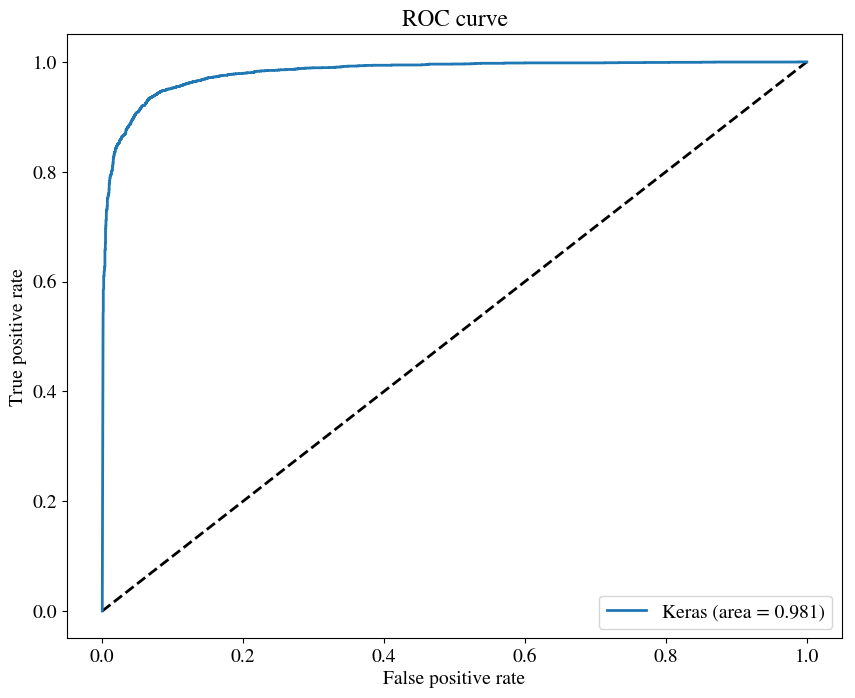

In [26]:
#https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, predictions)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Problem 6 (5 points)

Display the 5 images [worst] misclassified images for each class.  Worst is in brackets since certain architectures may only make a binary decision rather than a score.  In that case, plot 5 of each.

WORST 5 Missclassified PORTRAITS:


<Figure size 2000x2000 with 0 Axes>

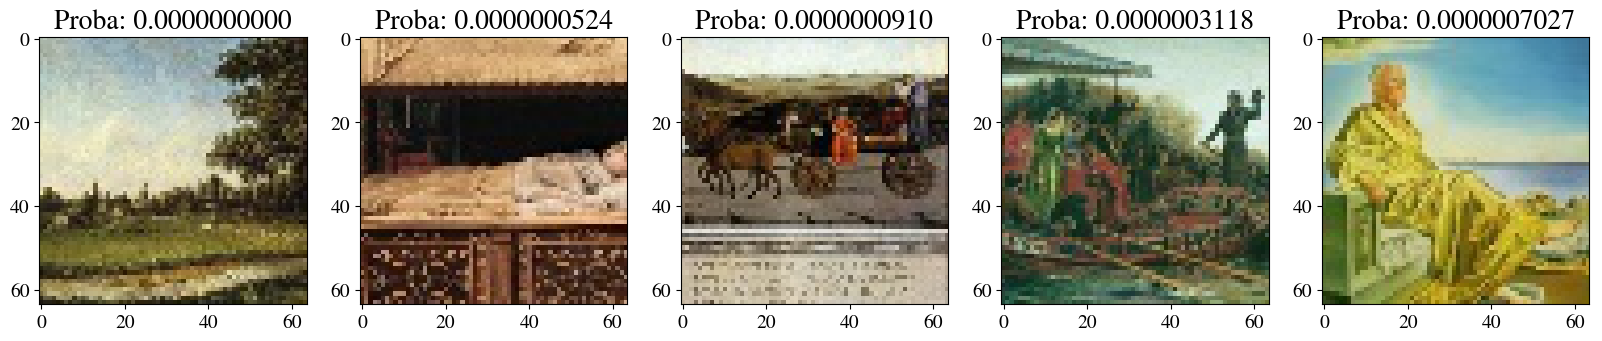


WORST 5 Missclassified LANDSCAPES:


<Figure size 2000x2000 with 0 Axes>

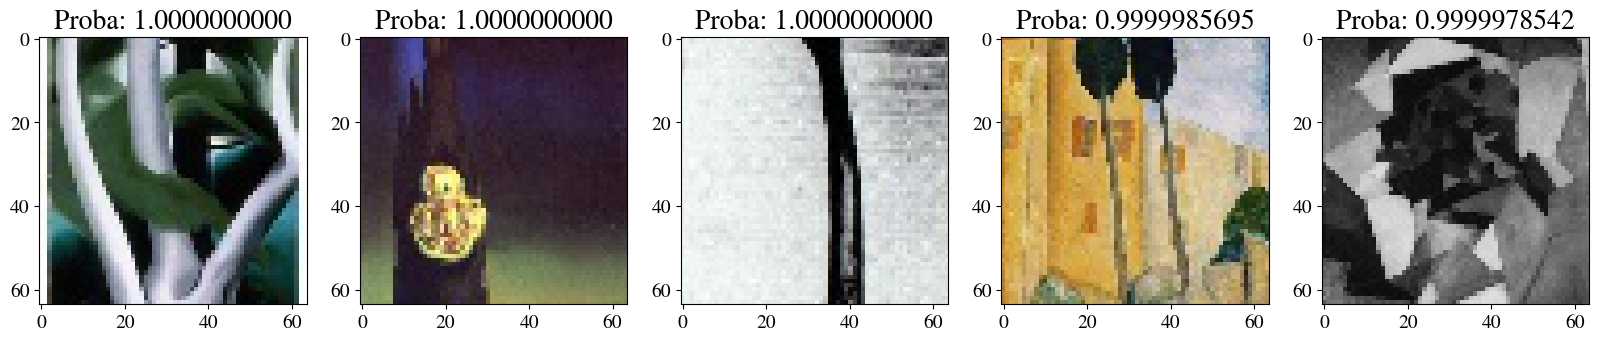

In [27]:
## Misclassified Portraits 
missed_portraits = []
missed_landscapes = []

def find_missclassified(tp):
    lst = []
    for i in range(len(indexes)):
        portrait_miss= (labels[i] == 1.0) & (predictions[i] < 0.5)
        landscape_miss = (labels[i] == 0.0) & (predictions[i] >= 0.5)
        if ((tp == "portrait") & portrait_miss) | ((tp == 'landscape') & landscape_miss)  :
            filename= 'images64/test/'+ test_generator.filenames[indexes[i]]
            #print(filename)
            #print(predictions[i])
            lst.append((filename,predictions[i]))
    return lst
 

missed_portraits = sorted(find_missclassified('portrait'), key = lambda tup: tup[1])
missed_landscapes = sorted(find_missclassified('landscape'), key = lambda tup: tup[1], reverse = True)


def plot_top_five (missed_list):    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    fig = plt.figure()
    fig.suptitle("Title for whole figure", fontsize=16)
    f, ax = plt.subplots(nrows=1, ncols=5)
    for i in range(5):
        filename, prediction = missed_list[i]
        test = image.load_img(filename)
        ax[i].set_title("Proba: %0.10f" % prediction , loc='center', fontsize = 20)
        ax[i].imshow(test)
    plt.show()
    return

print("WORST 5 Missclassified PORTRAITS:")
plot_top_five(missed_portraits)

print("\nWORST 5 Missclassified LANDSCAPES:")
plot_top_five(missed_landscapes)



## Problem 7 (2 points)
How many hours did this homework take you? The answer to this question will not affect your grade.

## Last step (3 points)
Save this notebook as LastnameFirstnameHW5.ipynb such as PriceDavid.ipynb. Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.